In [19]:
import torch
from fastai.basics import *
from fastai.vision.all import *
# from fastai.callback.tensorboard import TensorBoardCallback
from fastai.callback.tracker import SaveModelCallback

from pathlib import Path
import pandas as pd
import json

In [20]:
!pwd
!hostname

/home/m_zsuetam/uni/computational-intelligence/proj


AORUS-X470


In [21]:
ROOT_DIR = Path('.').resolve().parent
if ROOT_DIR.name != 'proj': # jupyter 
    ROOT_DIR = ROOT_DIR / 'proj'

DATASETS_DIR = ROOT_DIR / "datasets"
POTSDAM_DIR = DATASETS_DIR / "Potsdam-tiles-512"
assert POTSDAM_DIR.exists(), f"Potsdam dataset not found in {POTSDAM_DIR}"

EXPERIMENTS_DIR = ROOT_DIR / 'experiments'
LOGS_DIR = EXPERIMENTS_DIR / 'logs'
LOGS_DIR.mkdir(parents=True, exist_ok=True)

In [22]:
postdam_static = DATASETS_DIR/'Potsdam-static'
df_classes = pd.read_csv(postdam_static/'classes.csv')
df_classes

,class_id,name,color_name,color
0,0,Impervious surfaces,white,"(255, 255, 255)"
1,1,Buildings,blue,"(0, 0, 255)"
2,2,Low vegetation,cyan,"(0, 255, 255)"
3,3,Trees,green,"(0, 255, 0)"
4,4,Cars,yellow,"(255, 255, 0)"
5,5,Clutter,red,"(255, 0, 0)"
6,6,Undefined,black,"(0, 0, 0)"


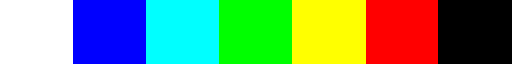

In [23]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap

def hex2rgb(hex_color):
    if isinstance(hex_color, tuple) or isinstance(hex_color, list):
        return tuple(hex_color)
    if hex_color.startswith('#'):
        hex_color = hex_color.lstrip('#')
        t = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
    else:
        t = tuple(int(x.strip()) for x in hex_color.strip('()').split(','))
    return t

ssd_cmap = ListedColormap(
    df_classes['color'].apply(lambda x: np.array(hex2rgb(x))/255.0).to_list(),
    name='skyscapes',
    N = len(df_classes)
) 

potsdam_plot_kwargs = {
    'vmin': 0,
    'vmax': len(df_classes) - 1,
    'cmap': ssd_cmap
}

potsdam_legend_kwargs = {
    'handles': [
        Patch(color=potsdam_plot_kwargs['cmap'](i), label=name) 
        for i, name in enumerate(df_classes.name.values)
    ],
    'bbox_to_anchor': (1.05, 1),
    'loc': 'upper left',
    'borderaxespad': 0.,
}

potsdam_plot_kwargs['cmap']

In [24]:
image_paths = L(sorted([f for f in get_image_files(POTSDAM_DIR) if f.parent != 'labels']))
image_paths

(#6625) [Path('/home/m_zsuetam/Documents/Uni/computational-intelligence/proj/datasets/Potsdam-tiles-512/image.png'),Path('/home/m_zsuetam/Documents/Uni/computational-intelligence/proj/datasets/Potsdam-tiles-512/train/images/top_potsdam_2_10_RGB_x0_y0.png'),Path('/home/m_zsuetam/Documents/Uni/computational-intelligence/proj/datasets/Potsdam-tiles-512/train/images/top_potsdam_2_10_RGB_x0_y1024.png'),Path('/home/m_zsuetam/Documents/Uni/computational-intelligence/proj/datasets/Potsdam-tiles-512/train/images/top_potsdam_2_10_RGB_x0_y1536.png'),Path('/home/m_zsuetam/Documents/Uni/computational-intelligence/proj/datasets/Potsdam-tiles-512/train/images/top_potsdam_2_10_RGB_x0_y2048.png'),Path('/home/m_zsuetam/Documents/Uni/computational-intelligence/proj/datasets/Potsdam-tiles-512/train/images/top_potsdam_2_10_RGB_x0_y2560.png'),Path('/home/m_zsuetam/Documents/Uni/computational-intelligence/proj/datasets/Potsdam-tiles-512/train/images/top_potsdam_2_10_RGB_x0_y3072.png'),Path('/home/m_zsuetam/D

In [25]:
import albumentations as A

class AlbumentationsTransform(Transform):
    split_idx = 0
    
    def __init__(self, aug): self.aug = aug
    def encodes(self, img: PILImage):
        aug_img = self.aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

# heavy lighting augmentation
a_tfms = A.Compose([
    A.RandomGamma(p=0.5),
    A.CLAHE(p=0.5), # Great for seeing details in shadows
    A.RandomBrightnessContrast(p=0.5),
    A.HueSaturationValue(p=0.3),
    # A.GridDistortion(p=0.3), # Helps with road undulations # cannot be used as the segmentation masks get distorted
])

In [26]:
# IMG_SIZE = 300
IMG_SIZE = 512

DB_MEAN = [0.3362390100955963, 0.35974231362342834, 0.3330190181732178]
DB_STD = [0.11687745898962021, 0.11572890728712082, 0.12002932280302048]
    
def get_y(img_path):
    img_path = Path(img_path)
    label_dir = img_path.parent.parent / "labels"
    label_name = img_path.name.replace("_RGB", "_label")
    return label_dir / label_name

db = DataBlock(
    blocks=(
        ImageBlock, 
        MaskBlock(codes=df_classes.name)
    ),
    get_y = get_y,
    splitter=GrandparentSplitter(valid_name='val'),
    item_tfms = [
        Resize((IMG_SIZE), method='nearest'),
        AlbumentationsTransform(a_tfms)
    ],
    batch_tfms=[
        Dihedral(), 
        *aug_transforms(
            max_rotate=10.0,    # Still useful for small "tilts" (non-90 degree)
            min_zoom=0.9,
            max_zoom=1.1,       # Keep conservative to preserve context
            
            max_lighting=0.4,    
            p_lighting=0.8,
            
            # Warp helps simulate slightly off-nadir camera angles
            max_warp=0.2,       
            p_affine=0.75,
        ),
        Normalize.from_stats(
            mean=tensor(DB_MEAN),
            std=tensor(DB_STD)
        )
    ],
)

In [27]:
desired_bs = 16
dls_bs = 4

dls = db.dataloaders(
    source=image_paths, 
    bs=dls_bs,
    num_workers=8 # Use 4 or 8 to keep the GPU fed
)

gradient_accum = GradientAccumulation(n_acc=desired_bs//dls_bs)
print(f"Using gradient accumulation with {desired_bs//dls_bs} steps")

Using gradient accumulation with 4 steps


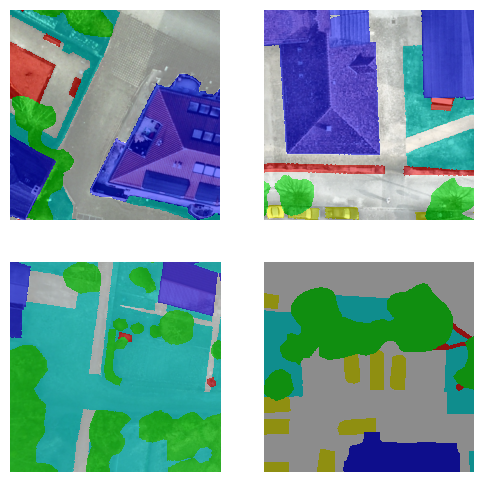

In [28]:
dls.show_batch(max_n=4, **potsdam_plot_kwargs)

In [29]:
loss_func = CrossEntropyLossFlat(axis=1)

In [30]:
pixel_accuracy = partial(accuracy, axis=1)

metrics = [
    pixel_accuracy,
    
    DiceMulti(), # F1 Score

    JaccardCoeffMulti(), # IoU
]

In [31]:
# resnet50       (best cost/perf)
# efficientnet_b3
# swin_t         (amazing on aerial)
# convnext_tiny  (excellent)

# arch = resnet50
model = resnet34

In [32]:
learn = unet_learner(
    dls, 
    model,
    loss_func=loss_func,
    metrics=metrics,
    pretrained=False,
).to_fp16()

learn.summary()

/home/m_zsuetam/anaconda3/envs/dl/lib/python3.11/site-packages/fastai/metrics.py:375: RuntimeWarning: Mean of empty slice
  return np.nanmean(binary_dice_scores)
/home/m_zsuetam/anaconda3/envs/dl/lib/python3.11/site-packages/fastai/metrics.py:392: RuntimeWarning: Mean of empty slice
  return np.nanmean(binary_jaccard_scores)


DynamicUnet (Input shape: 4 x 3 x 512 x 512)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 64 x 256 x 256  
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     4 x 64 x 128 x 128  
MaxPool2d                                                      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                      

resnet50: Total params: 339,071,460

resnet34: Total params: 41,221,668

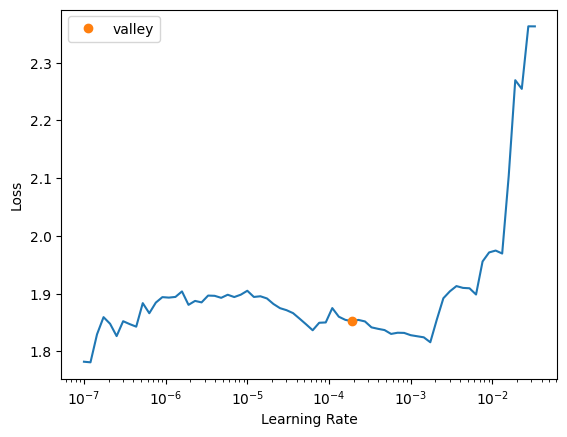

In [ ]:
suggested_lr = None
suggested_lr = learn.lr_find()

In [ ]:
lr = suggested_lr.valley if suggested_lr is not None else 2.5e-3
print(f"Using learning rate: {lr} {'(hardcoded)' if suggested_lr is None else '(suggested)'}")

Using learning rate: 0.00019054606673307717 (suggested)


In [33]:
from fastai.callback.tracker import SaveModelCallback
from fastai.callback.tracker import EarlyStoppingCallback

SaveCB = lambda fname: SaveModelCallback(
    monitor='jaccard_coeff_multi', 
    fname=fname, 
    comp=np.greater,
    with_opt=False
)

LogCB = lambda fname: CSVLogger(
    fname=LOGS_DIR/fname
)

ValidLossEarlyStoppingCB = lambda patience, min_delta=0.001: EarlyStoppingCallback(
    monitor='valid_loss',
    min_delta=min_delta,
    patience=patience
)

In [ ]:
learn.fit_one_cycle(
    100, 
    lr,
    cbs=[
        SaveCB('best_segmentation'),
        LogCB('segmentation_log.csv'),
        ValidLossEarlyStoppingCB(10),
        gradient_accum,
    ]
)

epoch,train_loss,valid_loss,accuracy,dice_multi,jaccard_coeff_multi,time
0,1.414531,1.311618,0.389466,0.221574,0.139250,06:40
1,1.381749,1.236943,0.469051,0.272391,0.177675,06:41
2,1.383587,1.244656,0.471842,0.309019,0.199686,06:40
3,1.345710,1.317088,0.449758,0.294688,0.190170,06:41
4,1.370083,1.260378,0.417288,0.335606,0.211852,06:40
5,1.314835,1.509702,0.399412,0.321216,0.204554,06:41
6,1.319661,1.504571,0.468664,0.358234,0.233003,06:41
7,1.223601,1.153315,0.529792,0.404893,0.272283,06:41
8,1.235747,1.196317,0.460054,0.372424,0.241841,06:40
9,1.172797,1.127905,0.555061,0.433729,0.297028,06:41


Better model found at epoch 0 with jaccard_coeff_multi value: 0.13925017870817855.
Better model found at epoch 1 with jaccard_coeff_multi value: 0.17767453132117725.
Better model found at epoch 2 with jaccard_coeff_multi value: 0.19968631085359126.
Better model found at epoch 4 with jaccard_coeff_multi value: 0.21185229695573682.
Better model found at epoch 6 with jaccard_coeff_multi value: 0.23300320289994858.
Better model found at epoch 7 with jaccard_coeff_multi value: 0.2722833057722733.
Better model found at epoch 9 with jaccard_coeff_multi value: 0.29702833791155003.
Better model found at epoch 10 with jaccard_coeff_multi value: 0.30622192871557746.
Better model found at epoch 11 with jaccard_coeff_multi value: 0.33499249696591527.
Better model found at epoch 14 with jaccard_coeff_multi value: 0.4329248263231245.
Better model found at epoch 16 with jaccard_coeff_multi value: 0.46357003700898153.
Better model found at epoch 19 with jaccard_coeff_multi value: 0.4699040738295561.
Be

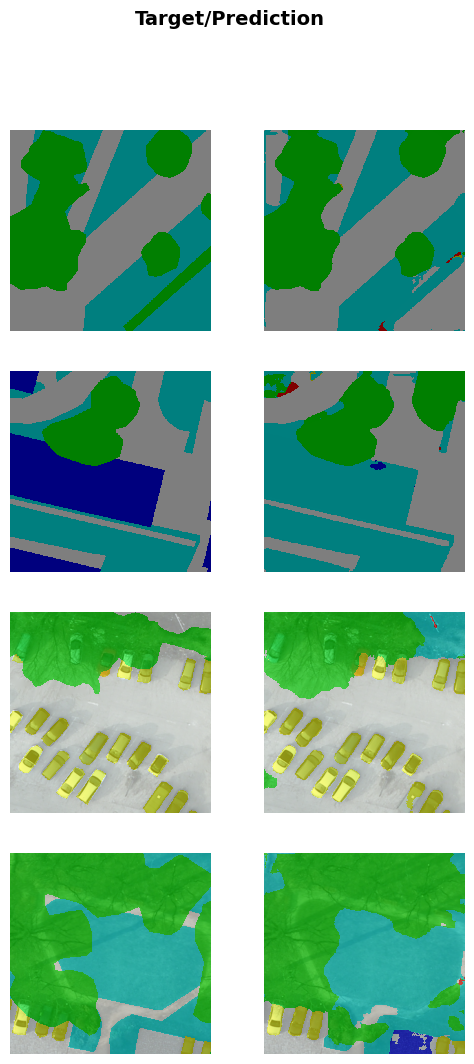

In [ ]:
learn.show_results(max_n=4, **potsdam_plot_kwargs)

In [39]:
learn.load('../notebooks/models/baseline_34_pretrained')

In [41]:
learn.export('experiments/new-ds/baseline_34_pretrained/baseline_34_pretrained.pkl')

Reference approaches:
- [InceptionResNetV2-UNet (81% Dice Coeff. & 86% Acc)](https://www.kaggle.com/code/ayushdabra/inceptionresnetv2-unet-81-dice-coeff-86-acc)
- [Aerial Image for Semantic Segmentation (~85% Dice Coeff.)](https://www.kaggle.com/code/aletbm/aerial-image-for-semantic-segmentation#Evaluation-metrics)
- [Unet segmentation implementation with ASPP](https://www.kaggle.com/discussions/general/205141)

? Edge-Refinement Network (ERN) are extremely effective for your aerial imagery task.

# CSE-UNet

In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [43]:
class ConvBlock(nn.Module):
    """
    Standard Conv -> BN -> ReLU block used throughout the network.
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, dilation=1):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, dilation=dilation, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

class DoubleConv(nn.Module):
    """
    The standard U-Net encoder block: Two Conv3x3 blocks.
    """
    def __init__(self, in_channels, out_channels, dropout_rate=0.2):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            ConvBlock(in_channels, out_channels),
            ConvBlock(out_channels, out_channels),
            nn.Dropout2d(dropout_rate)
        )

    def forward(self, x):
        return self.double_conv(x)

class RFB_Skip(nn.Module):
    """
    Multi-level RFB-based skip pathways (Section 2.2).
    It consists of two parallel paths:
    1. A stack of standard 3x3 convolutions (approximating a larger kernel).
    2. A single dilated convolution.
    The outputs are concatenated.
    """
    def __init__(self, in_channels, num_stack, dilation_rate):
        super(RFB_Skip, self).__init__()
        
        # Path 1: Stack of standard convolutions (Green blocks in diagram)
        # To emulate large kernels like 7x7, we stack 3x3 convs.
        stack_layers = []
        for _ in range(num_stack):
            # 1x1 convs are used in the bottom level as per text, 3x3 elsewhere
            k = 3 if num_stack > 1 else 1 
            p = 1 if num_stack > 1 else 0
            stack_layers.append(ConvBlock(in_channels, in_channels, kernel_size=k, padding=p))
        self.stack_path = nn.Sequential(*stack_layers)

        # Path 2: Dilated Convolution (Yellow blocks in diagram)
        # Note: Section 2.2 mentions matching receptive fields.
        # For the bottom level (dilation 1), it acts as a standard conv.
        self.dilated_path = ConvBlock(in_channels, in_channels, 
                                      kernel_size=3, 
                                      padding=dilation_rate, # Padding must equal dilation to keep size
                                      dilation=dilation_rate)

    def forward(self, x):
        out_stack = self.stack_path(x)
        out_dilated = self.dilated_path(x)
        # Concatenate features from both paths
        return torch.cat([out_stack, out_dilated], dim=1)

class CSE_UNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=1):
        super(CSE_UNet, self).__init__()
        
        filters = [64, 128, 256, 512, 1024]

        # --- ENCODER (Dual-Path) ---
        
        # Level 1
        self.enc1_main = DoubleConv(in_channels, filters[0])
        self.pool1 = nn.MaxPool2d(2)
        # Aux Path 1: Conv7x7 stride 2 (Section 2.3)
        self.enc1_aux = nn.Sequential(
            nn.Conv2d(in_channels, filters[0], kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(filters[0])
        )

        # Level 2
        self.enc2_main = DoubleConv(filters[0], filters[1])
        self.pool2 = nn.MaxPool2d(2)
        # Aux Path 2: Conv5x5 stride 2
        self.enc2_aux = nn.Sequential(
            nn.Conv2d(filters[0], filters[1], kernel_size=5, stride=2, padding=2, bias=False),
            nn.BatchNorm2d(filters[1])
        )

        # Level 3
        self.enc3_main = DoubleConv(filters[1], filters[2])
        self.pool3 = nn.MaxPool2d(2)
        # Aux Path 3: Conv3x3 stride 2
        self.enc3_aux = nn.Sequential(
            nn.Conv2d(filters[1], filters[2], kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(filters[2])
        )

        # Level 4
        self.enc4_main = DoubleConv(filters[2], filters[3])
        self.pool4 = nn.MaxPool2d(2)
        # Aux Path 4: Conv2x2 stride 2
        # Note: 2x2 kernel with stride 2 and padding 0 halves the dimension perfectly
        self.enc4_aux = nn.Sequential(
            nn.Conv2d(filters[2], filters[3], kernel_size=2, stride=2, padding=0, bias=False),
            nn.BatchNorm2d(filters[3])
        )

        # Bridge
        self.bridge = DoubleConv(filters[3], filters[4])

        # --- RFB SKIP PATHWAYS ---
        
        # According to Section 2.2 and Diagram
        # Top (Level 1): Stack of 3, Dilation 7
        self.rfb1 = RFB_Skip(filters[0], num_stack=3, dilation_rate=7)
        # Level 2: Stack of 2, Dilation 5
        self.rfb2 = RFB_Skip(filters[1], num_stack=2, dilation_rate=5)
        # Level 3: Stack of 1 (3x3), Dilation 3
        self.rfb3 = RFB_Skip(filters[2], num_stack=1, dilation_rate=3)
        # Level 4: Stack of 1 (1x1), Dilation 1
        # Text says: "one convolution layer with 1x1... and one dilated... dilation rate of 1"
        # We pass num_stack=1, but internal logic handles the 1x1 kernel switch for the bottom layer
        self.rfb4 = RFB_Skip(filters[3], num_stack=1, dilation_rate=1) 
        
        # Note on RFB4: The stack logic in `RFB_Skip` uses 3x3 by default. 
        # We need to manually override or create a specific block if strict adherence to "1x1" 
        # for the stack path is required. I added logic in RFB_Skip to handle this.

        # --- DECODER ---
        
        # Since RFB concatenates output, skip channels are doubled
        
        # Decoder 4
        self.up4 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.up_conv4 = nn.Conv2d(filters[4], filters[3], kernel_size=1) # Conv1x1 after upsample
        self.dec4 = DoubleConv(filters[3] + (filters[3] * 2), filters[3]) # Input = Prev + Skip(RFB x2)

        # Decoder 3
        self.up3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.up_conv3 = nn.Conv2d(filters[3], filters[2], kernel_size=1)
        self.dec3 = DoubleConv(filters[2] + (filters[2] * 2), filters[2])

        # Decoder 2
        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.up_conv2 = nn.Conv2d(filters[2], filters[1], kernel_size=1)
        self.dec2 = DoubleConv(filters[1] + (filters[1] * 2), filters[1])

        # Decoder 1
        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.up_conv1 = nn.Conv2d(filters[1], filters[0], kernel_size=1)
        self.dec1 = DoubleConv(filters[0] + (filters[0] * 2), filters[0])

        # Final Output
        self.final_conv = nn.Conv2d(filters[0], num_classes, kernel_size=1)

    def forward(self, x):
        # --- ENCODER + DUAL PATH FUSION ---
        
        # Stage 1
        x1_main = self.enc1_main(x)
        x1_pool = self.pool1(x1_main)
        x1_aux = self.enc1_aux(x)
        # Fusion: Main (Pooled) + Aux
        x1_fused = x1_pool + x1_aux 
        # Apply ReLU after addition (Standard ResNet practice, though not explicitly drawn, implied by block logic)
        x1_fused = F.relu(x1_fused)

        # Stage 2
        x2_main = self.enc2_main(x1_fused)
        x2_pool = self.pool2(x2_main)
        x2_aux = self.enc2_aux(x1_fused)
        x2_fused = x2_pool + x2_aux
        x2_fused = F.relu(x2_fused)

        # Stage 3
        x3_main = self.enc3_main(x2_fused)
        x3_pool = self.pool3(x3_main)
        x3_aux = self.enc3_aux(x2_fused)
        x3_fused = x3_pool + x3_aux
        x3_fused = F.relu(x3_fused)

        # Stage 4
        x4_main = self.enc4_main(x3_fused)
        x4_pool = self.pool4(x4_main)
        x4_aux = self.enc4_aux(x3_fused)
        x4_fused = x4_pool + x4_aux
        x4_fused = F.relu(x4_fused)

        # Bridge
        x_bridge = self.bridge(x4_fused)

        # --- RFB SKIP GENERATION ---
        # The skips come from the fused encoder features before they went to the next level
        # Note: The diagram arrows for skips originate from the output of the "Main" double conv 
        # BEFORE pooling/fusion? Or from the fused result?
        # Looking at Fig 2: The arrows go Inputs -> Conv -> [Conv] -> right arrow to RFB.
        # This implies the skip comes from the STANDARD encoder path before pooling.
        
        s1 = self.rfb1(x1_main)
        s2 = self.rfb2(x2_main)
        s3 = self.rfb3(x3_main)
        s4 = self.rfb4(x4_main)

        # --- DECODER ---
        
        # Block 4
        d4 = self.up4(x_bridge)
        d4 = self.up_conv4(d4)
        # Concatenate with RFB Skip 4
        d4 = torch.cat([d4, s4], dim=1)
        d4 = self.dec4(d4)

        # Block 3
        d3 = self.up3(d4)
        d3 = self.up_conv3(d3)
        d3 = torch.cat([d3, s3], dim=1)
        d3 = self.dec3(d3)

        # Block 2
        d2 = self.up2(d3)
        d2 = self.up_conv2(d2)
        d2 = torch.cat([d2, s2], dim=1)
        d2 = self.dec2(d2)

        # Block 1
        d1 = self.up1(d2)
        d1 = self.up_conv1(d1)
        d1 = torch.cat([d1, s1], dim=1)
        d1 = self.dec1(d1)

        return self.final_conv(d1)

In [44]:
arch_cse = CSE_UNet(in_channels=3, num_classes=len(df_classes)).to('cuda')
# arch_cse.smooth_loss = torch.tensor(0.0)

In [45]:
learn_cse: Learner = Learner(
    dls, 
    arch_cse,
    loss_func = CrossEntropyLossFlat(axis=1),
    # loss_func = CombinedLoss(dice_weight=0.4),
    metrics = metrics,
    wd=0.0005
).to_fp16()

learn_cse.summary()

/home/m_zsuetam/anaconda3/envs/dl/lib/python3.11/site-packages/fastai/metrics.py:375: RuntimeWarning: Mean of empty slice
  return np.nanmean(binary_dice_scores)
/home/m_zsuetam/anaconda3/envs/dl/lib/python3.11/site-packages/fastai/metrics.py:392: RuntimeWarning: Mean of empty slice
  return np.nanmean(binary_jaccard_scores)


CSE_UNet (Input shape: 4 x 3 x 512 x 512)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 64 x 512 x 512  
Conv2d                                    1728       True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Dropout2d                                                      
____________________________________________________________________________
                     4 x 64 x 256 x 256  
MaxPool2d                                                      
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
____________________________________________________________________________
                

Total params: 36,988,807

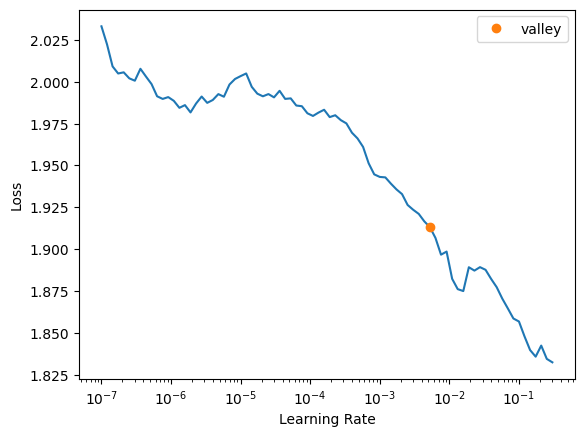

In [ ]:
suggested_lr = None
suggested_lr = learn_cse.lr_find()

In [46]:
suggested_lr = None # bacause it was 0.001 in the paper

In [26]:
lr = suggested_lr.valley if suggested_lr is not None else 2.5e-4
print(f"Using learning rate: {lr} {'(hardcoded)' if suggested_lr is None else '(suggested)'}")

Using learning rate: 0.00025 (hardcoded)


In [ ]:
learn_cse.fit_one_cycle(
    100, 
    lr,
    cbs=[
        SaveCB('best_segmentation'),
        LogCB('segmentation_log.csv'),
        ValidLossEarlyStoppingCB(10),
        gradient_accum,
    ]
)

epoch,train_loss,valid_loss,accuracy,dice_multi,jaccard_coeff_multi,time
0,1.650483,1.402227,0.480141,0.232403,0.153278,11:37
1,1.526794,1.343959,0.481506,0.272088,0.179107,11:38


Better model found at epoch 0 with jaccard_coeff_multi value: 0.1532775718482611.
Better model found at epoch 1 with jaccard_coeff_multi value: 0.17910732267828847.


## pahse 2

In [19]:
learn_cse.load('../notebooks/models/cse_best')

In [22]:
learn_cse.validate()

(#4) [0.5481874942779541,0.8463688492774963,0.7518005680127094,0.633769875110176]

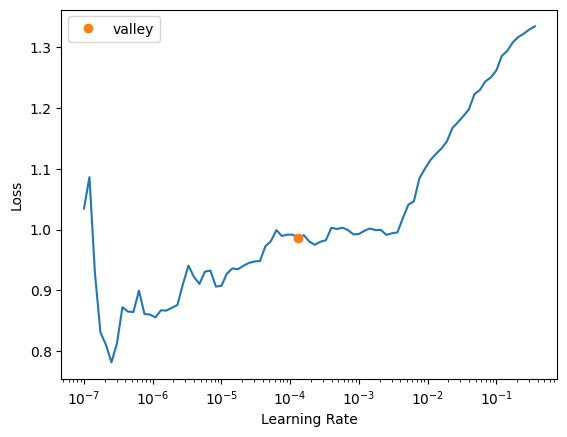

In [20]:
suggested_lr = None
suggested_lr = learn_cse.lr_find()

In [22]:
lr = suggested_lr.valley if suggested_lr is not None else 2.5e-4
print(f"Using learning rate: {lr} {'(hardcoded)' if suggested_lr is None else '(suggested)'}")

Using learning rate: 0.00013182566908653826 (suggested)


In [ ]:
learn_cse.fit_one_cycle(
    100, 
    lr_max=slice(1e-6, 1e-4),
    cbs=[
        SaveCB('best_segmentation'),
        LogCB('segmentation_log.csv'),
        ValidLossEarlyStoppingCB(20),
        gradient_accum,
    ]
)

epoch,train_loss,valid_loss,accuracy,dice_multi,jaccard_coeff_multi,time


## phase 3

In [27]:
learn_cse.load('../notebooks/models/cse_phase_2_best')

In [26]:
learn_cse.validate()

(#4) [0.507788896560669,0.8680351376533508,0.7819012394053781,0.6710915776704005]

In [32]:
import torch.nn.functional as F
class CombinedLoss:
    def __init__(self, dice_weight=0.5):
        self.dice_weight = dice_weight
        self.ce_weight = 1.0 - dice_weight
        
        # Your DiceLoss applies softmax internally (line 33) -> Expects Logits
        self.dice = DiceLoss(axis=1, reduction='mean') 
        
        # CE expects Logits
        self.ce = CrossEntropyLossFlat(axis=1, reduction='mean')

    def __call__(self, pred, targ):
        # Pass raw logits (pred) and integer targets (targ) to both.
        # DiceLoss._one_hot handles the target conversion automatically.
        return (
            self.dice(pred, targ) * self.dice_weight +
            self.ce(pred, targ) * self.ce_weight
        )
    
    def decodes(self, x):    
        return x.argmax(dim=1)

loss_func = CombinedLoss(dice_weight=0.5)

In [33]:
learn_cse.loss_func = loss_func

In [35]:
learn_cse

In [ ]:
learn_cse.fit_one_cycle(
    50, 
    lr_max=slice(1e-7, 1e-5),
    cbs=[
        SaveCB('best_segmentation'),
        LogCB('segmentation_log.csv'),
        ValidLossEarlyStoppingCB(10),
        gradient_accum,
    ]
)

epoch,train_loss,valid_loss,accuracy,dice_multi,jaccard_coeff_multi,time
0,0.737076,0.531594,0.845049,0.758425,0.642089,11:44


Better model found at epoch 0 with jaccard_coeff_multi value: 0.6420890286229873.


---

In [ ]:
model_name = 'cse_combined_loss'
learn_cse.load(f'../notebooks/models/{model_name}')
learn_cse.export(f'experiments/new-ds/{model_name}/{model_name}.pkl')

/home/m_zsuetam/anaconda3/envs/dl/lib/python3.11/site-packages/fastai/learner.py:67: UserWarning: Saved file doesn't contain an optimizer state.
  elif with_opt: warn("Saved file doesn't contain an optimizer state.")


: 

: 

: 

: 

: 

# interpretation of results

In [39]:
learn_loaded = learn_cse.load('best_segmentation', weights_only=True)

In [ ]:
# learn_loaded = learn.load('baseline_best', weights_only=False).to_fp16()
learn_loaded = learn_cse.load('cse_best', weights_only=False).to_fp16()

In [ ]:
learn_loaded.validate()

baseline model:  [0.4814046323299408,0.8252015709877014,0.7546336489729758,0.6331117555758458]

cse model:       [0.5484769344329834,0.8462911248207092,0.7514245712148022,0.6334320035269213]

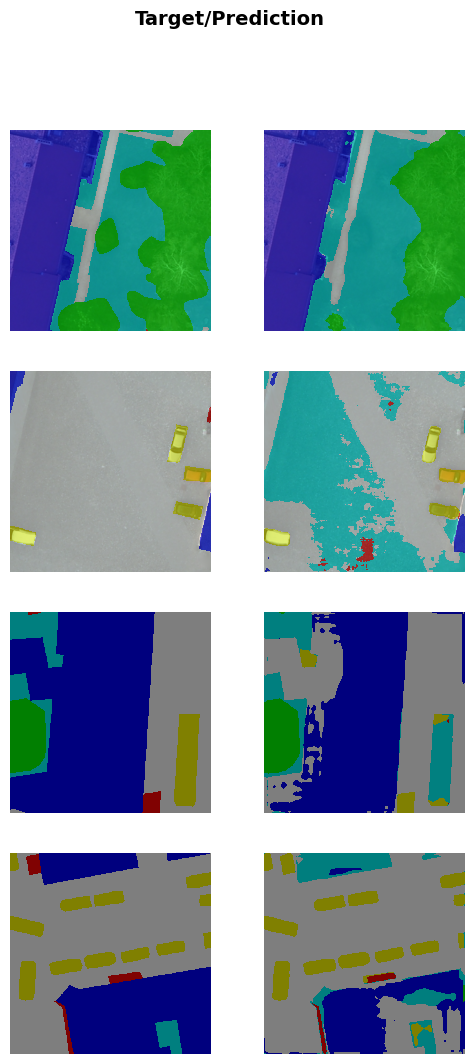

In [23]:
learn_loaded.show_results(max_n=4, **potsdam_plot_kwargs)

In [25]:
import utils.segmentation_interpretation as segm_utils
import importlib
importlib.reload(segm_utils)
from utils.segmentation_interpretation import MySegmentationInterpretation

# preds, targs = learn.tta()
# preds, targs, losses = learn.get_preds(dl=learn.dls.valid, with_loss=True)
preds, targs = learn_loaded.get_preds(dl=learn_loaded.dls.valid)

: 

In [ ]:
interp = MySegmentationInterpretation(
    learn_loaded,
    learn_loaded.dls.valid,
    preds,
    targs,
    torch.tensor([0 for _ in range(len(targs))]),
    df_classes=df_classes
)

In [ ]:
df_result_classes = interp.stats_per_class()
print(df_result_classes.to_markdown())

In [ ]:
interp.plot_df_result_classes(df_result_classes)

In [ ]:
interp.show_confidence_and_uncertainty(10)

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
for idx in range(df_classes.shape[0]):
    interp.show_results_per_class(idx, n_samples=3)